In [1]:
### Always import these tools as you will need them to do many calculations
import numpy as np
import scipy as sy

### For plotting! These are useful things I've used over the years, but not all are needed
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
heatmapcolour = cm.coolwarm
heatmapcolour.set_bad('w',1.)
from matplotlib.dates import DateFormatter, MinuteLocator, HourLocator, MonthLocator, DayLocator
import datetime

### This packages is just useful for plotting and keeping track of uncertainties and errors
### I plan on using it later, once an error estimate can be determined from the data
'''
import uncertainties
from uncertainties import ufloat
from uncertainties import umath
from uncertainties.umath import *  # sin(), etc.
from uncertainties import unumpy  # Array manipulation
from uncertainties import ufloat_fromstr
'''

### Also not needed but handy for doing algebra
import sympy as sm
from sympy.solvers.ode import dsolve
sm.init_printing()

### Super important! This is how we read and plot our data
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### This is how we can import the data if a password is ever required
import requests
from os import getcwd

import Constantspy3 as const

In [33]:
# I put these here, as when they were in the cell above, they tended
# to not get listened to, and the plot fontsize would stay at microscopic
# levels. Now they jump up to the proper size without running the 1st
# cell twice.

plt.rcParams.update({'font.size': 20})
mp.rc('xtick', labelsize=20)     
mp.rc('ytick', labelsize=20)

In [3]:
def HelpDocs():
    """
    This Jupyter Notebook seeks to help users interact and use the data from
    https://github.com/datasets/covid-19 
    which is maintained by the team at the Johns Hopkins University Center 
    for Systems Science and Engineering (CSSE).
    
    It also uses the Canadian provincial dataset found at
    https://www.canada.ca/en/public-health/services/diseases/2019-novel-coronavirus-infection.html
    

    This Notebook imports three datasets:
    countries-aggregated.csv
    worldwide-aggregated.csv
    covid19.csv

    and creates pandas arrays which are then useful for plotting as well as data
    interpretation.

    There are three functions in this Notebook:
    1: CovidCountryData()  <-- uses countries-aggregated.csv
    2: CovidWorldData()    <-- uses worldwide-aggregated.csv
    3: CADProvince()       <-- uses covid19.csv

    To see more information on these functions please use

    >>> print(CovidCountryData.__doc__)

    or

    >>> print(CovidWorldData.__doc__)
    
    or
    
    >>> print(CADProvinceData.__doc__)
    
    For printing help please use:
    
    >>> print(printingDocs.__doc__)
    """
    
def printingDocs():
    '''
    For creating plots using matplotlib, here are a few links I've found helpful:
    
    1: https://matplotlib.org/api/markers_api.html
    2: https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/linestyles.html
    3: https://xkcd.com/color/rgb/
    
    1: Is the dcoumentation for the available markers useable in the matplotlib 
    functions plot() or scatter(). For this project, I've been using  plot() with
    markers as it conviniently makes a scatter plot with a connecting line, saving
    me from using an ax.plot() followed by an ax.scatter() of the same data. I'm
    lazy, go away...
    
    an example of its usage is:
    
    >>> ax.plot(xaxis_data, yaxis_data, marker = 4)
    
    A quick check of the link shows that marker = 4 calls the caretleft marker
    while using marker = '4' would have called the tri_right marker. Also, yes
    using marker = '$DATA$' allows you to use latex format for a marker style,
    and in this case would have put the word DATA at every data point.
    Just remember. With great power, comes great responsibility.
    
    2: Is the documentaion for the available linestyles used in the matplotlib
    function plot(). Calling plot() without defining a linestyle will simply 
    create a solid line. Also, as fun as this link is, the top 4 results are aslo
    achieved by using 
    
    linestyle = '-'  <-- solid
    linestyle = '.'  <-- dotted
    linestyle = '--'  <-- dashed
    linestyle = '-.'  <-- dashdot
    
    an example of its usage is:
    
    >>> ax.plot(xaxis_data, yaxis_data, linestyle = '-.')
    
    3: Is the documentation for many of the available colours in matplotlib.
    Randal Munroe created a list of nearly 1000 colours and gave their HTML code
    which can then be use in our code. The hero we need really...
    
    an example of its usage is:
    
    >>> ax.plot(xaxis_data, yaxis_data, color = '#0343df')  <-- blue, 1st row, 3 left
    
    Note that the # is required for HTML code to work, so not having it will create
    an error message. These are bad and should be avoided.
    
    Other fun things to do with colour are the markerfacecolor and markeredgecolor
    commands for markers in the plot() function, as well as fillstyle. 
    
    markerfacecolor controls the interior marker colour and is HTML colour friendly
    markeredgecolor controls the exterior marker colour and is HTML colour friendly
    fillstyle controls wether the interior can be coloured at all.
    fillstyle = 'none' removes the makerfacecolor command and renders the interior of
    the marker transparent. There's more it can do but you can fall down that rabbit
    hole on your own Alice... https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.plot.html
    
    All of these can be used together in the same plot() to create unique
    representations of the data. Please be unique responsibly.
    
    An example of a plot would be as follows:
    
    save_on = False
    sizes = 10    
    f1, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(24, 15))
  
    ax1.plot(Canada_len, Canada_1000['Recovered'],                                             # This is the Data in (x,y) format
            color = '#000000', linestyle = '--',                                               # This controls the lines
            markerfacecolor = '#fd4659', markeredgecolor = '#aa2704',                          # This controls the markers
            marker = 'P', markersize = sizes,                                                  # This controls their type and size
            label='Canada: Max Recovered '+ str(Canada_1000['Confirmed'][Canada_len.size -1])) # This controls the label
    
    ax1.legend(ncol=1, frameon=False, loc=2, scatterpoints=1, markerscale=1, fontsize=25)      # This controls the legend for the label

    ax1.set_ylabel('Confirmed Cases')
    ax1.set_xlabel('Days Since 1000 Cases')
    ax1.set_title('Recovered: ' + EndDate[len(EndDate)-1])

    if save_on:
        f1.savefig('CanadaRecovered.png')
        f1.savefig('CanadaRecovered.pdf')
        plt.close()
    else:
        plt.show()
        
    '''
    
def CovidCountryData(name, marker):
    '''
    1: CovidCountryData() takes the data from countries-aggregated.csv and
    returns the country the user inputs, as well as a dataset beginning from
    a chosen marker; 1000 is the marker used in the example and creates a dataset
    that begins when the country obtained 1000 or more confirmed cases.

    Canada, Canada_1000, Canada_len = CovidCountryData('Canada', 1000)

    So here, we obtained the data pertaining to Canada and created a dataset of
    the values for Canada beginning when they hit the 1000 confirmed cases mark.
    This function also returns a handy linspace of the length of Canada_1000 for
    easy printing.

    A sample of the Canada data is:

    >>> Canada

        Date	Confirmed  Recovered   Deaths	NewCases   Infected
    2020-01-27	  1.0	      0.0	0.0	  0.0	      1.0
    2020-01-28	  2.0	      0.0	0.0	  1.0	      2.0
    2020-01-29	  2.0	      0.0	0.0	  0.0	      2.0
    2020-01-30	  2.0	      0.0	0.0	  0.0	      2.0
    2020-01-31	  4.0	      0.0	0.0	  2.0	      4.0

    Note that the returned country data has a DateTimeIndex and not a regula integer
    index. This has been done to simplify plotting. It also kept a column for Dates
    because I haven't deleted it... I've been using it as a convenient str of the
    dates. :) Also of note is that there are two new columns compared to the OG data:

    1.a: 'NewCases'
    1.b: 'Infected'

    1.a: 'NewCases' is new cases per day and is simply found by taking:

    Canada['Confirmed'][i] - Canada['Confirmed'][i-1].

    1.b: 'Infected' is the minimum infected value and is calculated by taking the
    total # of Confirmed cases and subtracting the recovered and the dead:

    Canada['Confirmed'] - Canada['Recovered'] - Canada['Deaths']

    Recall that for pandas arrays, calling a column is done by naming the column.
    for example

    >>> Canada["Confirmed"]

     Datetime
    2020-01-27        1.0
    2020-01-28        2.0
    2020-01-29        2.0
    2020-01-30        2.0
    2020-01-31        4.0
    2020-02-01        4.0
    2020-02-02        4.0
    2020-02-03        4.0
    2020-02-04        4.0

    Here we see the DateTimeIndex, as well as the confirmed data.
    '''
    formater = '%Y-%m-%d' ### DateTime Index Format
    
    ### This is getting the indexes where the country we want is located
    indexor = CountryCovidData['Country'].where(
        CountryCovidData['Country'] == name)
    indexor = indexor.dropna()
    
    ### This bit uses the above indexes to grab the data from each column.
    ### There is probably a better way, but this works for now
    Dates = CountryCovidData['Date'][indexor.index]
    Confirm = CountryCovidData['Confirmed'][indexor.index]
    Recov = CountryCovidData['Recovered'][indexor.index]
    Dead = CountryCovidData['Deaths'][indexor.index]
    ### This makes the 0's before a country reports any case
    ### become NaN for easy removal later
    for i in Confirm.index:
        if Confirm[i] < 1:
            Confirm[i] = np.nan
            Dates[i] = np.nan
            Recov[i] = np.nan
            Dead[i] = np.nan  
    ### This bit calculates the # of new cases per day
    NewCases = np.zeros(indexor.size)
    for i in range(1, indexor.size):
        NewCases[i] = Confirm[Confirm.index[i]] -  Confirm[Confirm.index[i-1]]
    ### This Determines the minimum number of infected 
    minInfected = Confirm - (Recov + Dead)   # Recov + Dead = Removed & Infected = Confirmed - Removed
    ### This puts it all into a list
    namesData = {'Date': Dates, 'Confirmed': Confirm,
                 'Recovered': Recov, 'Deaths': Dead, "NewCases": NewCases, 'Infected': minInfected}
    ### This puts that list into a pandas data frame
    Datanames = pd.DataFrame(data=namesData)
    ### This drops all os those NAN Values we created
    Datanames = Datanames.dropna()
    ### This turns the 'Date' column into a DateTime formated column
    Datanames['Datetime'] = pd.to_datetime(Datanames['Date'], format=formater)
    ### This is superfluous... huh... might delete later

    Final = pd.DataFrame(data=Datanames)
    ### This converts the index to a Datetime index so when you plot, you can do it by date easier
    ### I then remove the DateTime column as we don't need it
    Final = Final.set_index(pd.DatetimeIndex(Final['Datetime']))
    ### Note I might also drop the "Date" column as well as we really don't need it 
    Final = Final.drop(['Datetime'], axis=1)
    Final = Final.drop(['Date'], axis=1)
    
    ### This does the above but only for where the #confirmed > marker
    ### This standardizes the dates for all countries
    ### It doesn't need a daily counter so I don't include it
    marker_index = Datanames['Confirmed'].where(
        Datanames['Confirmed'] >= marker)
    marker_index = marker_index.dropna()

    Dates = Datanames['Date'][marker_index.index]
    Confirm = Datanames['Confirmed'][marker_index.index]
    Recov = Datanames['Recovered'][marker_index.index]
    Dead = Datanames['Deaths'][marker_index.index]
    minInfected = Datanames['Infected'][marker_index.index]
    
    namesData = {'Date': Dates, 'Confirmed': Confirm,
                 'Recovered': Recov, 'Deaths': Dead, 'Infected': minInfected}
    Datanames = pd.DataFrame(data=namesData)
    Datanames['Datetime'] = pd.to_datetime(Datanames['Date'], format=formater)
    Final_Marker = pd.DataFrame(data=Datanames)
    Final_Marker = Final_Marker.set_index(
        pd.DatetimeIndex(Final_Marker['Datetime']))
    Final_Marker = Final_Marker.drop(['Datetime'], axis=1)
    Final_Marker = Final_Marker.drop(['Date'], axis=1)
    
    ### This makes an integer linsapce that is the length of the marker data set for plotting
    ### It goes from (0,max) as max is the end day of the data and 0 is the
    ### date that marker was hit
    marker_len = np.arange(0, Final_Marker['Confirmed'].size, 1)
    
    return Final, Final_Marker, marker_len

def CovidWorldData():
    '''
    2: CovidWorldData() takes the data from worldwide-aggregated.csv and creates
    a DateTimeIndex from the 'Data', as well as two calculated columns for the
    # new cases per day, 'NewCases', and a minimum infected, 'Infected'. These were
    calculated the same way as was done in CovidCountryData(). For more Information
    please use:
    
    >>> print(CovidCountryData.__doc__)
    
    A sample of CovidWorldData() gives:
    
    >>> WorldCovidData = CovidWorldData()
    >>> WorldCovidData

    	        Confirmed  Recovered	Deaths	Increase rate	NewCases  Infected
        Date
    2020-01-22	  555	      28	  17	     NaN	   0.0	    510
    2020-01-23	  654	      30	  18	  17.837838	   99.0	    606
    2020-01-24	  941	      36	  26	  43.883792	   287.0    879
    2020-01-25	  1434	      39	  42	  52.391073	   493.0    1353
    2020-01-26	  2118	      52	  56	  47.698745	   684.0    2010
    2020-01-27	  2927	      61	  82	  38.196412	   809.0    2784
    
    Recall that for pandas arrays, calling a column is done by naming the column.
    for example

    >>> WorldCovidData["Confirmed"]
    
        Date
    2020-01-22        555
    2020-01-23        654
    2020-01-24        941
    2020-01-25       1434
    2020-01-26       2118
    2020-01-27       2927
    2020-01-28       5578
    2020-01-29       6166    
    '''
    # I'm importing the data an automatically converting the "Date" column
    # into a DateTimeIndex as we don't need an integer index for this data.
    Data = pd.read_csv(url_github + 'worldwide-aggregated.csv', index_col='Date', parse_dates=True)
    ### Here we create the NewCases column as before
    NewCases = np.zeros(Data['Confirmed'].size)
    for i in range(1, Data['Confirmed'].size):
        NewCases[i] = Data['Confirmed'][Data.index[i]] -  Data['Confirmed'][Data.index[i-1]]
    ### Now we insert it into the pandas array we made
    Data.insert(loc=4, column='NewCases', value=NewCases)
    ### Now we create an Infected column as before
    Data['Infected'] = Data['Confirmed'] - Data['Recovered'] - Data['Deaths']
    return Data

def CADProvinceData(name):
    '''
    3: CADProvince() takes the data from covid19.csv and allows the user
    to obtain the current values for the COVID-19 outbreak for each Canadian
    province. 
    
    A sample of CADProvince() gives:
    
    >>> BritColum = CADProvince('British Columbia')
    >>> BritColum

                Confirmed	Recovered	Deaths	NewCases	Tests
      Datetime					
    2020-01-31  	1         NaN   	 0.0      1.0   	 NaN
    2020-02-08  	4         NaN   	 0.0      3.0   	 NaN
    2020-02-16  	5         NaN   	 0.0      1.0   	 NaN
    2020-02-21  	6         NaN   	 0.0      1.0   	 NaN
    2020-02-24  	6         NaN   	 0.0      0.0   	 NaN
    
    Recall that for pandas arrays, calling a column is done by naming the column.
    for example

    >>> BritColum["Confirmed"]
    
     Datetime
    2020-01-31       1
    2020-02-08       4
    2020-02-16       5
    2020-02-21       6
    2020-02-24       6
    2020-02-25       7
    2020-02-26       7   
    '''
    
    ### So this gets the provincial data for canada...
    ### but the format is shit... fuck me
    
    formater = '%d-%m-%Y' ### DateTime Index Format
    
    ### This is getting the indexes where the country we want is located
    indexor = CanadaProvince['prname'].where(
        CanadaProvince['prname'] == name)
    indexor = indexor.dropna()    
    ### This bit uses the above indexes to grab the data from each column.
    ### There is probably a better way, but this works for now
    Dates = CanadaProvince['date'][indexor.index]
    Confirm = CanadaProvince['numconf'][indexor.index]
    Recov = CanadaProvince['numrecover'][indexor.index]
    Dead = CanadaProvince['numdeaths'][indexor.index]
    NewCases = CanadaProvince['numtoday'][indexor.index]
    Tested = CanadaProvince['numtested'][indexor.index]
    
    # Can't get a min infected because the numrecover is full on NaN's... idiots
    # If they change that, I'll reimpliment this
    #minInfected = Confirm - (Recov + Dead)   # Recov + Dead = Removed & Infected = Confirmed - Removed
    ### This puts it all into a list
    namesData = {'Confirmed': Confirm, 'Recovered': Recov, 
                 'Deaths': Dead, "NewCases": NewCases, 
                 'Tests': Tested, 'Date': Dates}#, 'Infected': minInfected}
    ### This puts that list into a pandas data frame
    Datanames = pd.DataFrame(data=namesData)
    ### This makes a Datetime column to make a DateTimeIndex
    Datanames['Datetime'] = pd.to_datetime(Datanames['Date'], format=formater)
    ### This converts the index to a Datetime index so when you plot, you can do it by date easier
    Datanames = Datanames.set_index(pd.DatetimeIndex(Datanames['Datetime']))
    ### I then remove the DateTime and Date columns as we don't need them
    Datanames = Datanames.drop(['Datetime'], axis=1)
    Datanames = Datanames.drop(['Date'], axis=1)
    
    return Datanames

In [4]:
print(HelpDocs.__doc__)


    This Jupyter Notebook seeks to help users interact and use the data from
    https://github.com/datasets/covid-19 
    which is maintained by the team at the Johns Hopkins University Center 
    for Systems Science and Engineering (CSSE).
    
    It also uses the Canadian provincial dataset found at
    https://www.canada.ca/en/public-health/services/diseases/2019-novel-coronavirus-infection.html
    

    This Notebook imports three datasets:
    countries-aggregated.csv
    worldwide-aggregated.csv
    covid19.csv

    and creates pandas arrays which are then useful for plotting as well as data
    interpretation.

    There are three functions in this Notebook:
    1: CovidCountryData()  <-- uses countries-aggregated.csv
    2: CovidWorldData()    <-- uses worldwide-aggregated.csv
    3: CADProvince()       <-- uses covid19.csv

    To see more information on these functions please use

    >>> print(CovidCountryData.__doc__)

    or

    >>> print(CovidWorldData.__doc__)
    

In [5]:
### Sources Data ###
url_github = "https://raw.githubusercontent.com/datasets/covid-19/master/data/"
url_cadprov = 'https://health-infobase.canada.ca/src/data/covidLive/covid19.csv'

In [6]:
CountryCovidData = pd.read_csv(url_github + 'countries-aggregated.csv')

# Here I just ran the function on the world-aggregated.csv for you
# enjoy...
WorldCovidData = CovidWorldData()


CanadaProvince = pd.read_csv(url_cadprov)

In [7]:
# For saving the graphs. 
#   'True' for saving
#   'False' for not saving
save_on = False
# I also tend to put this with every graph anyways, so I can only save
# that graph is I want to, while not running the risk of overwriting
# a graph I didn't want to.

# This gets the end date from the data and is usefull for plotting
# in titles
EndDate = WorldCovidData.index[len(WorldCovidData.index)-1].strftime("%d of %B, %Y")
# >>> ax.set_title('North America: ' + EndDate[len(EndDate)-1])
# prints "North America: 2020 April 11" for a title

### Here is the marker placement
marker = 1000

In [8]:
# Here is a list of the countries found in the data on the last day
# Just copy/paste these names into the CovidCountryData() function 
# to obtain that country's data.
Countries = CountryCovidData['Country'].where(CountryCovidData['Date'] == CountryCovidData['Date'][CountryCovidData['Date'].size-1])
Countries.dropna(inplace=True)
for i in Countries.index:
    print(Countries[i])
    
print()
print('There are ' + str(len(Countries.index)) + ' countries available in this dataset as of ' + EndDate)

Afghanistan
Albania
Algeria
Andorra
Angola
Antigua and Barbuda
Argentina
Armenia
Australia
Austria
Azerbaijan
Bahamas
Bahrain
Bangladesh
Barbados
Belarus
Belgium
Belize
Benin
Bhutan
Bolivia
Bosnia and Herzegovina
Botswana
Brazil
Brunei
Bulgaria
Burkina Faso
Burma
Burundi
Cabo Verde
Cambodia
Cameroon
Canada
Central African Republic
Chad
Chile
China
Colombia
Congo (Brazzaville)
Congo (Kinshasa)
Costa Rica
Cote d'Ivoire
Croatia
Cuba
Cyprus
Czechia
Denmark
Diamond Princess
Djibouti
Dominica
Dominican Republic
Ecuador
Egypt
El Salvador
Equatorial Guinea
Eritrea
Estonia
Eswatini
Ethiopia
Fiji
Finland
France
Gabon
Gambia
Georgia
Germany
Ghana
Greece
Grenada
Guatemala
Guinea
Guinea-Bissau
Guyana
Haiti
Holy See
Honduras
Hungary
Iceland
India
Indonesia
Iran
Iraq
Ireland
Israel
Italy
Jamaica
Japan
Jordan
Kazakhstan
Kenya
Korea, South
Kosovo
Kuwait
Kyrgyzstan
Laos
Latvia
Lebanon
Liberia
Libya
Liechtenstein
Lithuania
Luxembourg
MS Zaandam
Madagascar
Malawi
Malaysia
Maldives
Mali
Malta
Mauritania
Ma

In [9]:
Countries_1000 = CountryCovidData['Country'][Countries.index].where(CountryCovidData['Confirmed'] >= marker)
Countries_1000.dropna(inplace=True)
print('Country                         Confirmed')
print()
for i in Countries_1000.index:
    print(Countries_1000[i] + " {:30d}".format(CountryCovidData['Confirmed'][i]))
    
print()
print('There are ' + str(len(Countries_1000.index)) + ' countries with over ' + str(marker) + ' confirmed cases as of ' + EndDate)

Country                         Confirmed

Algeria                           2629
Argentina                           2839
Armenia                           1291
Australia                           6547
Austria                          14749
Azerbaijan                           1398
Bahrain                           1881
Bangladesh                           2456
Belarus                           4779
Belgium                          38496
Bosnia and Herzegovina                           1285
Brazil                          38654
Cameroon                           1017
Canada                          35632
Chile                          10088
China                          83805
Colombia                           3792
Croatia                           1871
Cuba                           1035
Czechia                           6746
Denmark                           7580
Dominican Republic                           4680
Ecuador                           9468
Egypt                          

In [10]:
# Here is a list of the provinces found in the data on the last day
# Just copy/paste these names into the CADProvinceData() function 
# to obtain that country's data.
Provinces = CanadaProvince['prname'].where(CanadaProvince['date'] == CanadaProvince['date'][CanadaProvince['date'].size-1])
Provinces.dropna(inplace=True)
for i in Provinces.index:
    print(Provinces[i])

British Columbia
Alberta
Saskatchewan
Manitoba
Ontario
Quebec
Newfoundland and Labrador
New Brunswick
Nova Scotia
Prince Edward Island
Yukon
Northwest Territories
Nunavut
Repatriated travellers
Canada


# So here is where the core code stops.

From here on out, the rest of the code is yours to do with

as you see fit. You can add, or remove countries, create plots.

do math on columns as you see fit! If you have any comments please 

let me know.

In [14]:
### North America ###
Canada, Canada_1000, Canada_len = CovidCountryData('Canada', marker)
USA, USA_1000, USA_len = CovidCountryData('US', marker)
Mexico, Mexico_1000, Mexico_len = CovidCountryData('Mexico', marker)

### South America ###
Brazil, Brazil_1000, Brazil_len = CovidCountryData('Brazil', marker)
Chile, Chile_1000, Chile_len = CovidCountryData('Chile', marker)
Argentina, Argentina_1000, Argentina_len = CovidCountryData('Argentina', marker)
Colombia, Colombia_1000, Colombia_len = CovidCountryData('Colombia', marker)
Venezuela, Venezuela_1000, Venezuela_len = CovidCountryData('Venezuela', marker)
Ecuador, Ecuador_1000, Ecuador_len = CovidCountryData('Ecuador', marker)
CostaRica, CostaRica_1000, CostaRica_len = CovidCountryData('Costa Rica', marker)

### Europe ### 
# I cherry picked the data and grabbed ones I seen were >1000
# and also fairly large countries
Spain, Spain_1000, Spain_len = CovidCountryData('Spain', marker)
Italy, Italy_1000, Italy_len = CovidCountryData('Italy', marker)
Austria, Austria_1000, Austria_len = CovidCountryData('Austria', marker)
Belgium, Belgium_1000, Belgium_len = CovidCountryData('Belgium', marker)
Denmark, Denmark_1000, Denmark_len = CovidCountryData('Denmark', marker)
France, France_1000, France_len = CovidCountryData('France', marker)
Finland, Finland_1000, Finland_len = CovidCountryData('Finland', marker)
Germany, Germany_1000, Germany_len = CovidCountryData('Germany', marker)
Netherlands, Netherlands_1000, Netherlands_len = CovidCountryData('Netherlands', marker)
Norway, Norway_1000, Norway_len = CovidCountryData('Norway', marker)
Portugal, Portugal_1000, Portugal_len = CovidCountryData('Portugal', marker)
Romania, Romania_1000, Romania_len = CovidCountryData('Romania', marker)
Russia, Russia_1000, Russia_len = CovidCountryData('Russia', marker)
Sweden, Sweden_1000, Sweden_len = CovidCountryData('Sweden', marker)
Switzerland, Switzerland_1000, Switzerland_len = CovidCountryData('Switzerland', marker)
Turkey, Turkey_1000, Turkey_len = CovidCountryData('Turkey', marker)
Ukraine, Ukraine_1000, Ukraine_len = CovidCountryData('Ukraine', marker)
UnitedKingdom, UnitedKingdom_1000, UnitedKingdom_len = CovidCountryData('United Kingdom', marker)
Poland, Poland_1000, Poland_len = CovidCountryData('Poland', marker)
Israel, Israel_1000, Israel_len = CovidCountryData('Israel', marker)

### Asia ###
China, China_1000, China_len = CovidCountryData('China', marker)
SKorea, SKorea_1000, SKorea_len = CovidCountryData('Korea, South', marker)

### SE Asia + Aussie and NZ ###
Philippines, Philippines_1000, Philippines_len = CovidCountryData('Philippines', marker)
Indonesia, Indonesia_1000, Indonesia_len = CovidCountryData('Indonesia', marker)
Australia, Australia_1000, Australia_len = CovidCountryData('Australia', marker)
NewZealand, NewZealand_1000, NewZealand_len = CovidCountryData('New Zealand', marker)
        

In [15]:
### Canadian Provincial Data
CanadaProv = CADProvinceData('Canada')
BritCol = CADProvinceData('British Columbia')
Alberta = CADProvinceData('Alberta')
Ontario = CADProvinceData('Ontario')
Quebec = CADProvinceData('Quebec')
Saskatchewan = CADProvinceData('Saskatchewan')

In [16]:
USA_norm1 = const.NormData(USA_1000['Confirmed'], USA_1000['Confirmed'])#, norm = 'yes')
Mexico_norm1 = const.NormData(Mexico_1000['Confirmed'], Mexico_1000['Confirmed'])#, norm = 'yes')

Canada_norm1 = const.NormData(Canada_1000['Confirmed'], Canada_1000['Confirmed'])#, norm = 'yes')
Italy_norm1 = const.NormData(Italy_1000['Confirmed'], Italy_1000['Confirmed'])#, norm = 'yes')

In [73]:
Sweden_pop = 10.23
Swizterland_pop = 8.57
Denmark_pop = 5.806
Norway_pop = 5.368
USA_pop = 328.2
Mexico_pop = 126.2
Canada_pop = 37.59
Italy_pop = 60.36

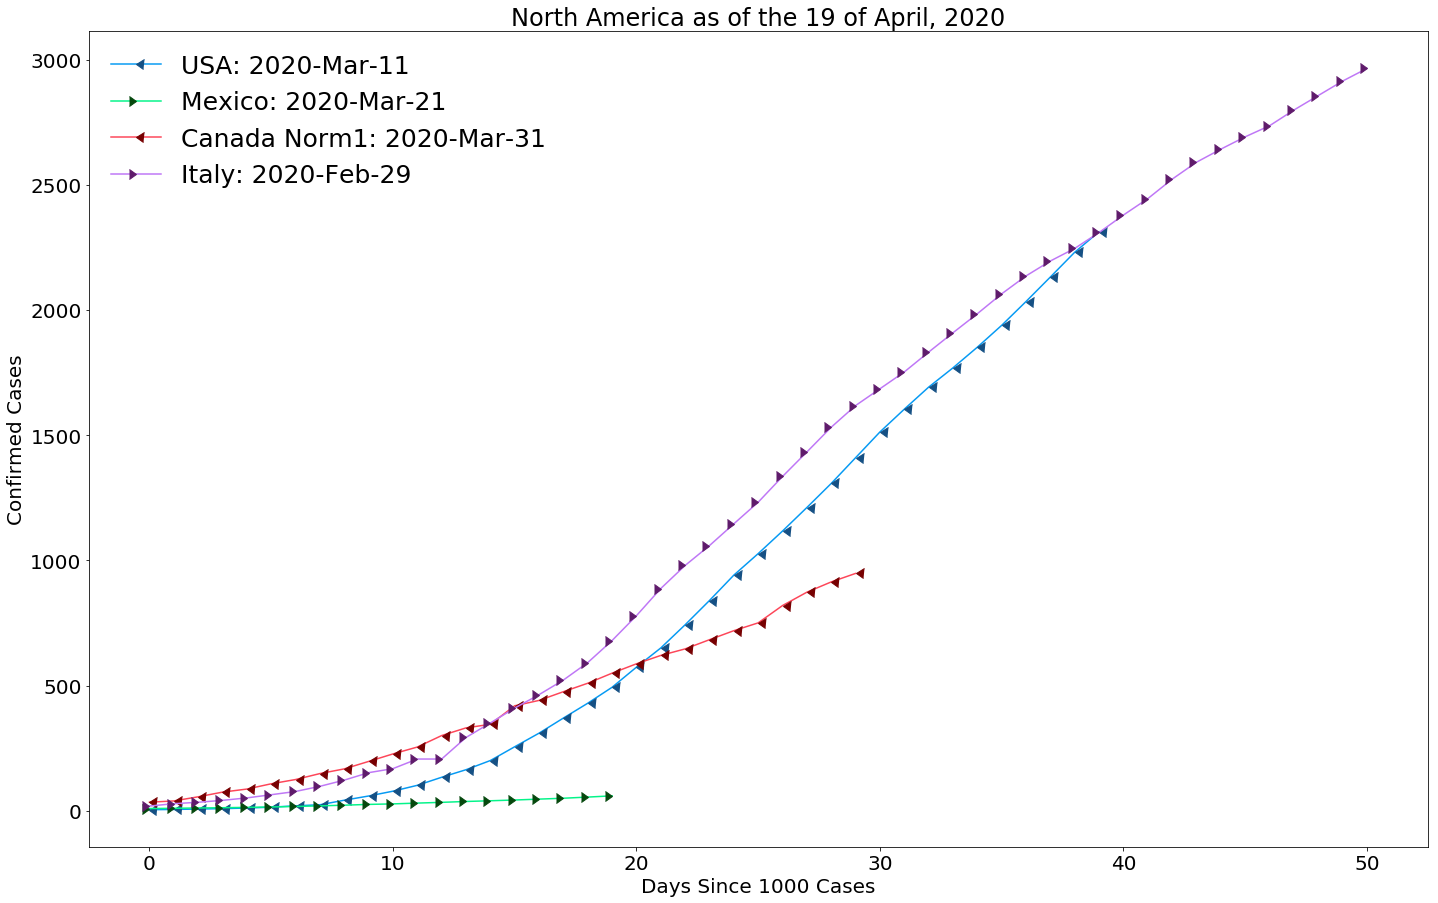

In [76]:
#fd4659  -  watermelon
#069af3  -  azure
#04f489  -  turquoise green
#f5bf03  -  golden
#bf77f6  -  light purple
#a8a495  -  greyish
#d1b26f  -  tan

#770001  -  Blood
#155084  -  light navy
#05480d  -  british racing green
#dc4d01  -  deep orange
#5f1b6b  -  indigo
#000000  -  black
#653700  -  brown

#59656d  -  slate grey
#343837  -  charcoal
#75bbfd  -  sky blue
#fdc1c5  -  pale rose

save_on = False
sizes = 10

f1, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(24, 15))


ax1.plot(USA_len, USA_1000['Confirmed']/USA_pop, 
         color = '#069af3', 
         markerfacecolor = '#155084', markeredgecolor = '#155084',
         marker = 4, markersize = sizes, 
         label='USA: '+ USA_1000.index[0].strftime('%Y-%b-%d'))

ax1.plot(Mexico_len, Mexico_1000['Confirmed']/Mexico_pop, 
         color = '#04f489', 
         markerfacecolor = '#05480d', markeredgecolor = '#05480d',
         marker = 5, markersize = sizes, 
         label='Mexico: '+ Canada_1000.index[0].strftime('%Y-%b-%d'))

ax1.plot(Canada_len, Canada_1000['Confirmed']/Canada_pop, 
         color = '#fd4659', 
         markerfacecolor = '#770001', markeredgecolor = '#770001',
         marker = 4, markersize = sizes, 
         label='Canada Norm1: '+ Mexico_1000.index[0].strftime('%Y-%b-%d'))

ax1.plot(Italy_len, Italy_1000['Confirmed']/Italy_pop, 
         color = '#bf77f6', 
         markerfacecolor = '#5f1b6b', markeredgecolor = '#5f1b6b',
         marker = 5, markersize = sizes, 
         label='Italy: '+ Italy_1000.index[0].strftime('%Y-%b-%d'))


ax1.legend(ncol=1, frameon=False, loc=2, scatterpoints=1, markerscale=1, fontsize=25)

#ax1.set_ylim(0,325000)
#ax1.set_xlim(0,37)

ax1.set_ylabel('Confirmed Cases')
ax1.set_xlabel('Days Since 1000 Cases')
ax1.set_title('North America as of the ' + EndDate)

if save_on:
    f1.savefig('NorthAmerica.png')
    f1.savefig('NorthAmerica.pdf')
    plt.close()
else:
    plt.show()

#fd4659  -  watermelon
#069af3  -  azure
#04f489  -  turquoise green
#f5bf03  -  golden
#bf77f6  -  light purple
#a8a495  -  greyish
#d1b26f  -  tan

#aa2704  -  rust red
#155084  -  light navy
#05480d  -  british racing green
#dc4d01  -  deep orange
#5f1b6b  -  indigo
#155084  -  black
#653700  -  brown

#59656d  -  slate grey
#343837  -  charcoal
#75bbfd  -  sky blue
#fdc1c5  -  pale rose

save_on = False
sizes = 10

f1, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(24, 15))


ax1.plot(Brazil_len, Brazil_1000['Confirmed'], color = '#aa2704', marker = 4, markersize = sizes, 
         label='Brazil: '+ Brazil_1000.index[0].strftime('%Y-%b-%d'))

ax1.plot(Chile_len, Chile_1000['Confirmed'], color = '#155084', marker = 5, markersize = sizes, 
         label='Chile: '+ Chile_1000.index[0].strftime('%Y-%b-%d'))

ax1.plot(Argentina_len, Argentina_1000['Confirmed'], color = '#05480d', marker = 6, markersize = sizes, 
         label='Argentina: '+ Argentina_1000.index[0].strftime('%Y-%b-%d'))

ax1.plot(Colombia_len, Colombia_1000['Confirmed'], color = '#dc4d01', marker = 7, markersize = sizes, 
         label='Colombia: '+ Colombia_1000.index[0].strftime('%Y-%b-%d'))

ax1.plot(Ecuador_len, Ecuador_1000['Confirmed'], color = '#5f1b6b', marker = 7, markersize = sizes, 
         label='Ecuador: '+ Ecuador_1000.index[0].strftime('%Y-%b-%d'))


ax1.legend(ncol=1, frameon=False, loc=2, scatterpoints=1, markerscale=1, fontsize=25)

ax1.set_ylabel('Confirmed Cases')
ax1.set_xlabel('Days Since 1000 Cases')
ax1.set_title('South America as of the ' + EndDate)

#ax1.set_xlim(0,37)

if save_on:
    f1.savefig('SouthAmerica.png')
    f1.savefig('SouthAmerica.pdf')
    plt.close()
else:
    plt.show()

#fd4659  -  watermelon
#069af3  -  azure
#04f489  -  turquoise green
#f5bf03  -  golden
#bf77f6  -  light purple
#a8a495  -  greyish
#d1b26f  -  tan

#aa2704  -  rust red
#155084  -  light navy
#05480d  -  british racing green
#dc4d01  -  deep orange
#5f1b6b  -  indigo
#155084  -  black
#653700  -  brown

#59656d  -  slate grey
#343837  -  charcoal
#75bbfd  -  sky blue
#fdc1c5  -  pale rose

save_on = False
sizes = 10

f1, (ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=1, sharex=False, sharey=False, figsize=(24, 45))


### Top plot ###
ax1.plot(Spain_len, Spain_1000['Confirmed'], color = '#aa2704', marker = 4, markersize = sizes, 
         label='Spain: '+ Spain_1000.index[0].strftime('%Y-%b-%d'))

ax1.plot(Italy_len, Italy_1000['Confirmed'], color = '#155084', marker = 5, markersize = sizes, 
         label='Italy: '+ Italy_1000.index[0].strftime('%Y-%b-%d'))

ax1.plot(Germany_len, Germany_1000['Confirmed'], color = '#05480d', marker = 4, markersize = sizes, 
         label='Germany: '+ Germany_1000.index[0].strftime('%Y-%b-%d'))

ax1.plot(France_len, France_1000['Confirmed'], color = '#dc4d01', marker = 7, markersize = sizes, 
         label='France: '+ France_1000.index[0].strftime('%Y-%b-%d'))

ax1.plot(UnitedKingdom_len, UnitedKingdom_1000['Confirmed'], color = '#5f1b6b', marker = 7, markersize = sizes, 
         label='UK: '+ UnitedKingdom_1000.index[0].strftime('%Y-%b-%d'))

ax1.plot(Turkey_len, Turkey_1000['Confirmed'], color = '#653700', marker = 6, markersize = sizes, 
         label='Turkey: '+ Turkey_1000.index[0].strftime('%Y-%b-%d'))

### Middle Plot ###


ax2.plot(Belgium_len, Belgium_1000['Confirmed'], color = '#aa2704', marker = 7, markersize = sizes, 
         label='Belgium: '+ Belgium_1000.index[0].strftime('%Y-%b-%d'))

ax2.plot(Netherlands_len, Netherlands_1000['Confirmed'], color = '#155084', marker = 5, markersize = sizes, 
         label='Netherlands: '+ Netherlands_1000.index[0].strftime('%Y-%b-%d'))

ax2.plot(Austria_len, Austria_1000['Confirmed'], color = '#05480d', marker = 6, markersize = sizes, 
         label='Austria: '+ Austria_1000.index[0].strftime('%Y-%b-%d'))

ax2.plot(Portugal_len, Portugal_1000['Confirmed'], color = '#dc4d01', marker = 7, markersize = sizes, 
         label='Portugal: '+ Portugal_1000.index[0].strftime('%Y-%b-%d'))

ax2.plot(Switzerland_len, Switzerland_1000['Confirmed'], color = '#5f1b6b', marker = 5, markersize = sizes, 
         label='Switzerland: '+ Switzerland_1000.index[0].strftime('%Y-%b-%d'))

ax2.plot(Russia_len, Russia_1000['Confirmed'], color = '#653700', marker = 7, markersize = sizes, 
         label='Russia: '+ Russia_1000.index[0].strftime('%Y-%b-%d'))

### Bottom Plot ###
ax3.plot(Norway_len, Norway_1000['Confirmed'], color = '#aa2704', marker = 6, markersize = sizes, 
         label='Norway: '+ Norway_1000.index[0].strftime('%Y-%b-%d'))

ax3.plot(Romania_len, Romania_1000['Confirmed'], color = '#155084', marker = 7, markersize = sizes, 
         label='Romania: '+ Romania_1000.index[0].strftime('%Y-%b-%d'))

ax3.plot(Sweden_len, Sweden_1000['Confirmed'], color = '#05480d', marker = 4, markersize = sizes, 
         label='Sweden: '+ Sweden_1000.index[0].strftime('%Y-%b-%d'))

ax3.plot(Denmark_len, Denmark_1000['Confirmed'], color = '#dc4d01', marker = 7, markersize = sizes, 
         label='Denmark: '+ Denmark_1000.index[0].strftime('%Y-%b-%d'))

ax3.plot(Ukraine_len, Ukraine_1000['Confirmed'], color = '#5f1b6b', marker = 7, markersize = sizes, 
         label='Ukraine: '+ Ukraine_1000.index[0].strftime('%Y-%b-%d'))

ax3.plot(Poland_len, Poland_1000['Confirmed'], color = '#653700', marker = 7, markersize = sizes, 
         label='Poland: '+ Poland_1000.index[0].strftime('%Y-%b-%d'))


ax1.legend(ncol=1, frameon=False, loc=2, scatterpoints=1, markerscale=1, fontsize=20)
ax2.legend(ncol=1, frameon=False, loc=2, scatterpoints=1, markerscale=1, fontsize=20)
ax3.legend(ncol=1, frameon=False, loc=2, scatterpoints=1, markerscale=1, fontsize=20)

ax1.set_ylabel('Confirmed Cases')
ax1.set_xlabel('Days Since 1000 Cases')
ax1.set_title('Europe as of the ' + EndDate)

ax2.set_ylabel('Confirmed Cases')
ax2.set_xlabel('Days Since 1000 Cases')
ax2.set_title('Europe as of the ' + EndDate)

ax3.set_ylabel('Confirmed Cases')
ax3.set_xlabel('Days Since 1000 Cases')
ax3.set_title('Europe as of the ' + EndDate)

if save_on:
    f1.savefig('Europe.png')
    f1.savefig('Europe.pdf')
    plt.close()
else:
    plt.tight_layout()
    plt.show()

#fd4659  -  watermelon
#069af3  -  azure
#04f489  -  turquoise green
#f5bf03  -  golden
#bf77f6  -  light purple
#a8a495  -  greyish
#d1b26f  -  tan

#aa2704  -  rust red
#155084  -  light navy
#05480d  -  british racing green
#dc4d01  -  deep orange
#5f1b6b  -  indigo
#155084  -  black
#653700  -  brown

#59656d  -  slate grey
#343837  -  charcoal
#75bbfd  -  sky blue
#fdc1c5  -  pale rose

save_on = False
sizes = 10

f1, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(24, 15))

ax1.plot(Philippines_len, Philippines_1000['Confirmed'], color = '#aa2704', marker = 4, markersize = sizes, 
         label='Philippines: '+ Philippines_1000.index[0].strftime('%Y-%b-%d'))

ax1.plot(Indonesia_len, Indonesia_1000['Confirmed'], color = '#155084', marker = 5, markersize = sizes, 
         label='Indonesia: '+ Indonesia_1000.index[0].strftime('%Y-%b-%d'))

ax1.plot(Australia_len, Australia_1000['Confirmed'], color = '#5f1b6b', marker = 6, markersize = sizes, 
         label='Australia: '+ Australia_1000.index[0].strftime('%Y-%b-%d'))

ax1.plot(NewZealand_len, NewZealand_1000['Confirmed'], color = '#05480d', marker = 7, markersize = sizes, 
         label='NewZealand: '+ NewZealand_1000.index[0].strftime('%Y-%b-%d'))


ax1.legend(ncol=1, frameon=False, loc=4, scatterpoints=1, markerscale=1, fontsize=25)

ax1.set_ylabel('Confirmed Cases')
ax1.set_xlabel('Days Since 1000 Cases')
ax1.set_title('South Eastern Islands as of the ' + EndDate)

#ax1.set_xlim(0,37)

if save_on:
    f1.savefig('SEIslands.png')
    f1.savefig('SEIslands.pdf')
    plt.close()
else:
    plt.show()

In [ ]:
upper = 30000
lower = 10000

Confirmed_mid = CountryCovidData['Confirmed'].where((CountryCovidData['Confirmed'][Countries_1000.index] > lower) & (CountryCovidData['Confirmed'][Countries_1000.index] < upper))
Confirmed_mid.dropna(inplace=True)

print(len(Countries_1000[Confirmed_mid.index]))
print()
Countries_1000[Confirmed_mid.index]

#fd4659  -  watermelon
#069af3  -  azure
#04f489  -  turquoise green
#f5bf03  -  golden
#bf77f6  -  light purple
#a8a495  -  greyish
#d1b26f  -  tan

#aa2704  -  rust red
#155084  -  light navy
#05480d  -  british racing green
#dc4d01  -  deep orange
#5f1b6b  -  indigo
#000000  -  black
#653700  -  brown

#59656d  -  slate grey
#343837  -  charcoal
#75bbfd  -  sky blue
#fdc1c5  -  pale rose

save_on = False
sizes = 10

f1, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(24, 15))

ax1.plot(Canada_len, Canada_1000['Confirmed'], 
         color = '#aa2704', linestyle = '-.',
         markerfacecolor = '#aa2704', markeredgecolor = '#aa2704',
         marker = 5, markersize = sizes, 
         label='Canada: '+ Canada_1000.index[0].strftime('%Y-%b-%d'))

ax1.plot(Brazil_len, Brazil_1000['Confirmed'], 
         color = '#155084', linestyle = '--',
         markerfacecolor = '#155084', markeredgecolor = '#155084',
         marker = 4, markersize = sizes, 
         label='Brazil: '+ Brazil_1000.index[0].strftime('%Y-%b-%d'))

ax1.plot(Belgium_len, Belgium_1000['Confirmed'], 
         color = '#05480d', linestyle = '--',
         markerfacecolor = '#05480d', markeredgecolor = '#05480d',
         marker = 7, markersize = sizes, 
         label='Belgium: '+ Belgium_1000.index[0].strftime('%Y-%b-%d'))

ax1.plot(Netherlands_len, Netherlands_1000['Confirmed'], 
         color = '#dc4d01', linestyle = '--',
         markerfacecolor = '#dc4d01', markeredgecolor = '#dc4d01',
         marker = 5, markersize = sizes, 
         label='Netherlands: '+ Netherlands_1000.index[0].strftime('%Y-%b-%d'))

ax1.plot(Portugal_len, Portugal_1000['Confirmed'], 
         color = '#5f1b6b', linestyle = '--',
         markerfacecolor = '#5f1b6b', markeredgecolor = '#5f1b6b',
         marker = 7, markersize = sizes, 
         label='Portugal: '+ Portugal_1000.index[0].strftime('%Y-%b-%d'))

ax1.plot(Switzerland_len, Switzerland_1000['Confirmed'], 
         color = '#653700', linestyle = '--',
         markerfacecolor = '#653700', markeredgecolor = '#653700',
         marker = 5, markersize = sizes, 
         label='Switzerland: '+ Switzerland_1000.index[0].strftime('%Y-%b-%d'))

ax1.plot(Austria_len, Austria_1000['Confirmed'], 
         color = '#000000', linestyle = '--',
         markerfacecolor = '#000000', markeredgecolor = '#000000',
         marker = 6, markersize = sizes, 
         label='Austria: '+ Austria_1000.index[0].strftime('%Y-%b-%d'))

ax1.plot(Sweden_len, Sweden_1000['Confirmed'], 
         color = '#f5bf03', linestyle = '--',
         markerfacecolor = '#f5bf03', markeredgecolor = '#f5bf03',
         marker = 5, markersize = sizes, 
         label='Sweden: '+ Sweden_1000.index[0].strftime('%Y-%b-%d'))

ax1.plot(SKorea_len, SKorea_1000['Confirmed'], 
         color = '#069af3', linestyle = '--',
         markerfacecolor = '#069af3', markeredgecolor = '#069af3',
         marker = 7, markersize = sizes, 
         label='South Korea: '+ SKorea_1000.index[0].strftime('%Y-%b-%d'))

ax1.plot(Russia_len, Russia_1000['Confirmed'], 
         color = '#04f489', linestyle = '--',
         markerfacecolor = '#04f489', markeredgecolor = '#04f489',
         marker = 5, markersize = sizes, 
         label='Russia: '+ Russia_1000.index[0].strftime('%Y-%b-%d'))

ax1.plot(Israel_len, Israel_1000['Confirmed'], 
         color = '#bf77f6', linestyle = '--',
         markerfacecolor = '#bf77f6', markeredgecolor = '#bf77f6',
         marker = 6, markersize = sizes, 
         label='Israel: '+ Israel_1000.index[0].strftime('%Y-%b-%d'))


             

ax1.legend(ncol=1, frameon=False, loc=2, scatterpoints=1, markerscale=1, fontsize=25)

ax1.set_ylabel('Confirmed Cases')
ax1.set_xlabel('Days Since 1000 Cases')
ax1.set_title('Countries with between ' + str(lower) + ' and ' + str(upper) + ' Confirmed Cases as of the ' + EndDate)

if save_on:
    f1.savefig('15000Range.png')
    f1.savefig('15000Range.pdf')
    plt.close()
else:
    plt.show()

#fd4659  -  watermelon
#069af3  -  azure
#04f489  -  turquoise green
#f5bf03  -  golden
#bf77f6  -  light purple
#a8a495  -  greyish
#d1b26f  -  tan

#aa2704  -  rust red
#155084  -  light navy
#05480d  -  british racing green
#dc4d01  -  deep orange
#5f1b6b  -  indigo
#000000  -  black
#653700  -  brown

#59656d  -  slate grey
#343837  -  charcoal
#75bbfd  -  sky blue
#fdc1c5  -  pale rose

save_on = False
sizes = 10

f1, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(24, 15))


ax1.plot(Canada_len, Canada_1000['Confirmed'], color = '#fd4659', marker = 5, markersize = sizes, 
         label='Canada: '+ Canada_1000.index[0].strftime('%Y-%b-%d'))

ax1.plot(NewZealand_len, NewZealand_1000['Confirmed'], color = '#05480d', marker = 7, markersize = sizes, 
         label='NewZealand: '+ NewZealand_1000.index[0].strftime('%Y-%b-%d'))

ax1.plot(Sweden_len, Sweden_1000['Confirmed'], color = '#dc4d01', marker = 4, markersize = sizes, 
         label='Sweden: '+ Sweden_1000.index[0].strftime('%Y-%b-%d'))


ax1.legend(ncol=1, frameon=False, loc=2, scatterpoints=1, markerscale=1, fontsize=25)

#ax1.set_ylim(0,325000)

#ax1.xaxis.set_major_locator(MonthLocator())
#ax1.xaxis.set_major_formatter(DateFormatter('%b:%Y'))
#ax1.xaxis.set_minor_locator(DayLocator([15]))
#ax1.xaxis.set_minor_formatter(DateFormatter('%b:%d'))

#ax1.set_xlim([datetime.date(2020, 3, 8), datetime.date(2020, 4, 10)])


ax1.set_ylabel('Confirmed Cases')
ax1.set_xlabel('Days Since 1000 Cases')
ax1.set_title('North America: ' + EndDate)

if save_on:
    f1.savefig('Compare.png')
    f1.savefig('Compare.pdf')
    plt.close()
else:
    plt.show()

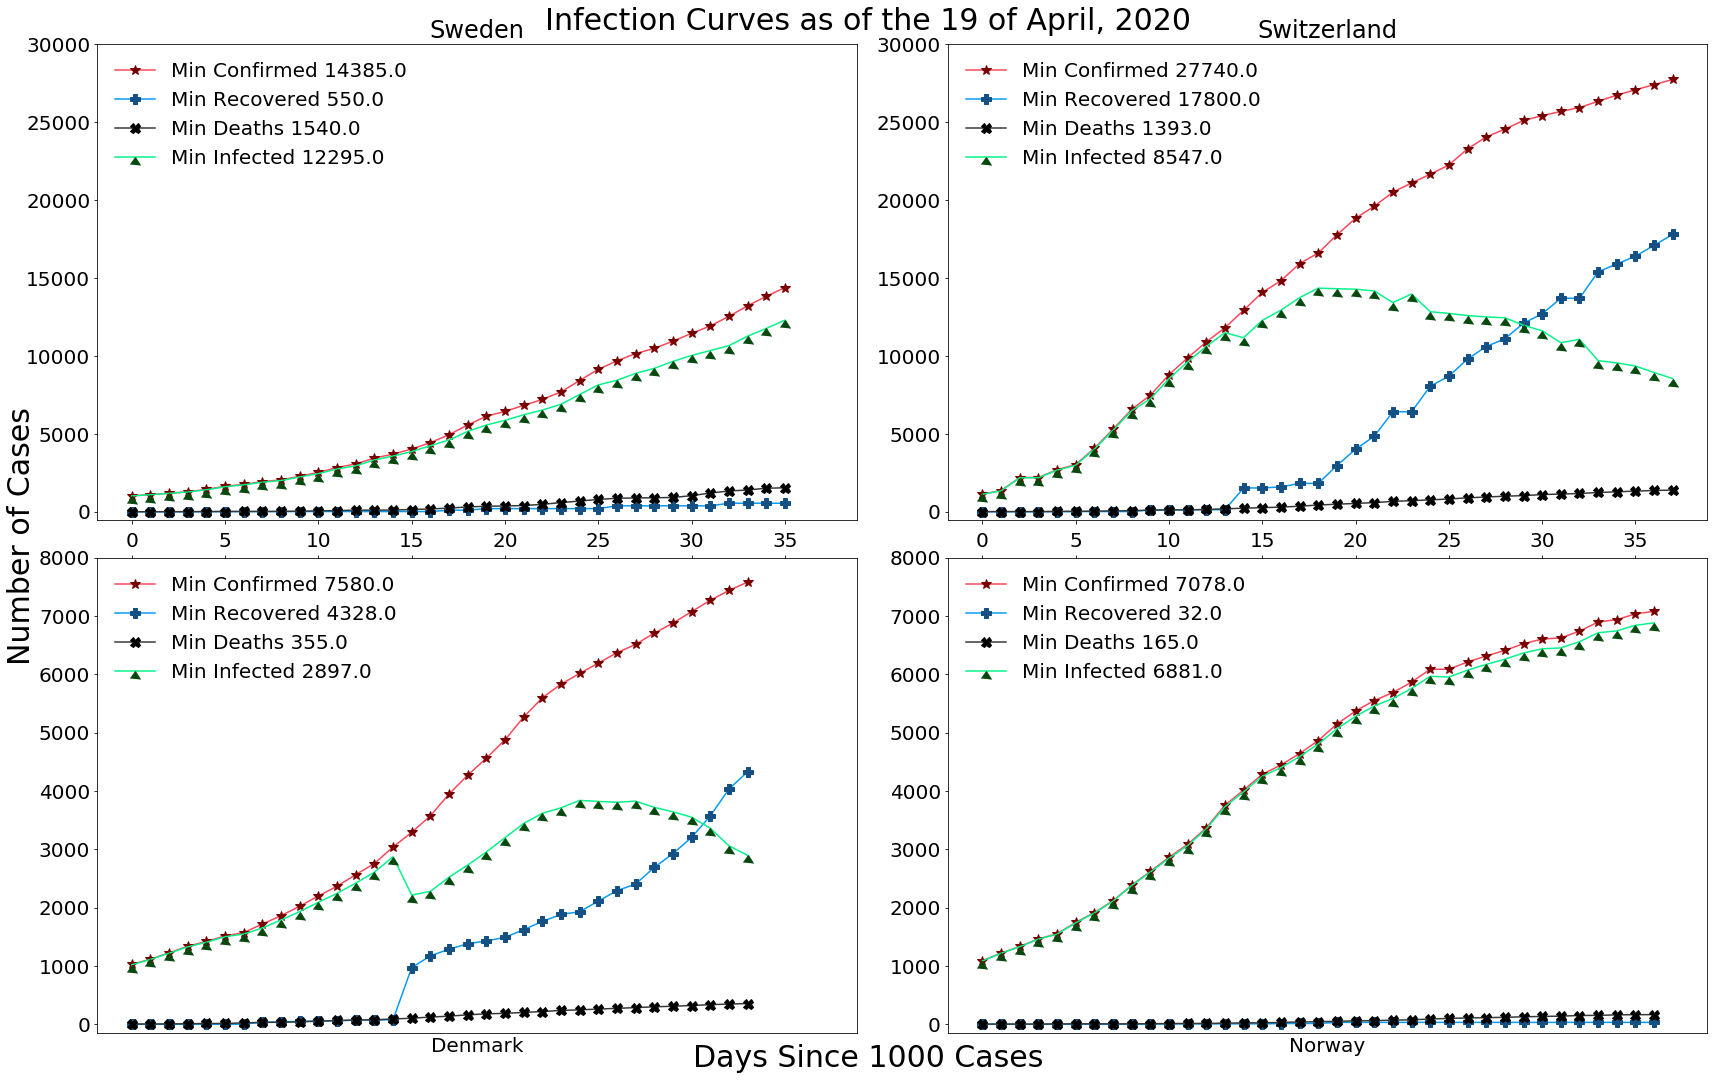

In [68]:
#fd4659  -  watermelon
#069af3  -  azure
#04f489  -  turquoise green
#f5bf03  -  golden
#bf77f6  -  light purple
#a8a495  -  greyish
#d1b26f  -  tan

#770001  -  Blood
#155084  -  light navy
#05480d  -  british racing green
#dc4d01  -  deep orange
#5f1b6b  -  indigo
#000000  -  black
#653700  -  brown

#59656d  -  slate grey
#343837  -  charcoal
#75bbfd  -  sky blue
#fdc1c5  -  pale rose

save_on = False
sizes = 10

f1, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=False, figsize=(24, 15))

ax1.plot(Sweden_len, Sweden_1000['Confirmed'], 
         color = '#fd4659', 
         markerfacecolor = '#770001', markeredgecolor = '#770001',
         marker = '*', markersize = sizes, 
         label='Min Confirmed '+ str(Sweden_1000['Confirmed'][Sweden_len.size -1]))

ax1.plot(Sweden_len, Sweden_1000['Recovered'], 
         color = '#069af3', 
         markerfacecolor = '#155084', markeredgecolor = '#155084',
         marker = 'P', markersize = sizes, 
         label='Min Recovered '+ str(Sweden_1000['Recovered'][Sweden_len.size -1]))

ax1.plot(Sweden_len, Sweden_1000['Deaths'], 
         color = '#343837', 
         markerfacecolor = '#000000', markeredgecolor = '#000000',
         marker = 'X', markersize = sizes, 
         label='Min Deaths '+ str(Sweden_1000['Deaths'][Sweden_len.size -1]))

ax1.plot(Sweden_len, Sweden_1000['Infected'], 
         color = '#04f489', 
         markerfacecolor = '#05480d', markeredgecolor = '#05480d',
         marker = 6, markersize = sizes, 
         label='Min Infected '+ str(Sweden_1000['Infected'][Sweden_len.size -1]))

ax2.plot(Switzerland_len, Switzerland_1000['Confirmed'], 
         color = '#fd4659', 
         markerfacecolor = '#770001', markeredgecolor = '#770001',
         marker = '*', markersize = sizes, 
         label='Min Confirmed '+ str(Switzerland_1000['Confirmed'][Switzerland_len.size -1]))

ax2.plot(Switzerland_len, Switzerland_1000['Recovered'], 
         color = '#069af3', 
         markerfacecolor = '#155084', markeredgecolor = '#155084',
         marker = 'P', markersize = sizes, 
         label='Min Recovered '+ str(Switzerland_1000['Recovered'][Switzerland_len.size -1]))

ax2.plot(Switzerland_len, Switzerland_1000['Deaths'], 
         color = '#343837', 
         markerfacecolor = '#000000', markeredgecolor = '#000000',
         marker = 'X', markersize = sizes, 
         label='Min Deaths '+ str(Switzerland_1000['Deaths'][Switzerland_len.size -1]))

ax2.plot(Switzerland_len, Switzerland_1000['Infected'], 
         color = '#04f489', 
         markerfacecolor = '#05480d', markeredgecolor = '#05480d',
         marker = 6, markersize = sizes, 
         label='Min Infected '+ str(Switzerland_1000['Infected'][Switzerland_len.size -1]))

ax3.plot(Denmark_len, Denmark_1000['Confirmed'], 
         color = '#fd4659', 
         markerfacecolor = '#770001', markeredgecolor = '#770001',
         marker = '*', markersize = sizes, 
         label='Min Confirmed '+ str(Denmark_1000['Confirmed'][Denmark_len.size -1]))

ax3.plot(Denmark_len, Denmark_1000['Recovered'], 
         color = '#069af3', 
         markerfacecolor = '#155084', markeredgecolor = '#155084',
         marker = 'P', markersize = sizes, 
         label='Min Recovered '+ str(Denmark_1000['Recovered'][Denmark_len.size -1]))

ax3.plot(Denmark_len, Denmark_1000['Deaths'], 
         color = '#343837', 
         markerfacecolor = '#000000', markeredgecolor = '#000000',
         marker = 'X', markersize = sizes, 
         label='Min Deaths '+ str(Denmark_1000['Deaths'][Denmark_len.size -1]))

ax3.plot(Denmark_len, Denmark_1000['Infected'], 
         color = '#04f489', 
         markerfacecolor = '#05480d', markeredgecolor = '#05480d',
         marker = 6, markersize = sizes, 
         label='Min Infected '+ str(Denmark_1000['Infected'][Denmark_len.size -1]))

ax4.plot(Norway_len, Norway_1000['Confirmed'], 
         color = '#fd4659', 
         markerfacecolor = '#770001', markeredgecolor = '#770001',
         marker = '*', markersize = sizes, 
         label='Min Confirmed '+ str(Norway_1000['Confirmed'][Norway_len.size -1]))

ax4.plot(Norway_len, Norway_1000['Recovered'], 
         color = '#069af3', 
         markerfacecolor = '#155084', markeredgecolor = '#155084',
         marker = 'P', markersize = sizes, 
         label='Min Recovered '+ str(Norway_1000['Recovered'][Norway_len.size -1]))

ax4.plot(Norway_len, Norway_1000['Deaths'], 
         color = '#343837', 
         markerfacecolor = '#000000', markeredgecolor = '#000000',
         marker = 'X', markersize = sizes, 
         label='Min Deaths '+ str(Norway_1000['Deaths'][Norway_len.size -1]))

ax4.plot(Norway_len, Norway_1000['Infected'], 
         color = '#04f489', 
         markerfacecolor = '#05480d', markeredgecolor = '#05480d',
         marker = 6, markersize = sizes, 
         label='Min Infected '+ str(Norway_1000['Infected'][Norway_len.size -1]))

ax1.legend(ncol=1, frameon=False, loc=2, scatterpoints=1, markerscale=1, fontsize=20)
ax2.legend(ncol=1, frameon=False, loc=2, scatterpoints=1, markerscale=1, fontsize=20)
ax3.legend(ncol=1, frameon=False, loc=2, scatterpoints=1, markerscale=1, fontsize=20)
ax4.legend(ncol=1, frameon=False, loc=2, scatterpoints=1, markerscale=1, fontsize=20)

ax1.set_ylim(-500, 30000)
ax2.set_ylim(-500, 30000)
ax3.set_ylim(-150, 8000)
ax4.set_ylim(-150, 8000)

#ax1.xaxis.set_major_locator(MonthLocator())
#ax1.xaxis.set_major_formatter(DateFormatter('%b:%Y'))
#ax1.xaxis.set_minor_locator(DayLocator([15]))
#ax1.xaxis.set_minor_formatter(DateFormatter('%b:%d'))

#ax1.set_xlim([datetime.date(2020, 3, 8), datetime.date(2020, 4, 10)])
ax1.set_title('Sweden')
ax2.set_title('Switzerland')
ax3.set_xlabel('Denmark')
ax4.set_xlabel('Norway')

ax3.xaxis.set_ticks_position('top')
ax3.tick_params(labelbottom='off', labeltop='on')

ax4.xaxis.set_ticks_position('top')
ax4.tick_params(labelbottom='off', labeltop='on')

plt.tight_layout()
f1.text(0.01, 0.6, 'Number of Cases', ha='center', fontsize=30, rotation = 90)
f1.text(0.5, 0.97, 'Infection Curves as of the ' + EndDate, ha='center', fontsize=30)
f1.text(0.5, 0.01, 'Days Since 1000 Cases', ha='center', fontsize=30)
f1.subplots_adjust(hspace=0.08, wspace=0.12)


if save_on:
    f1.savefig('ScanMinInfected.png')
    f1.savefig('ScanMinInfected.pdf')
    plt.close()
else:
    plt.show()

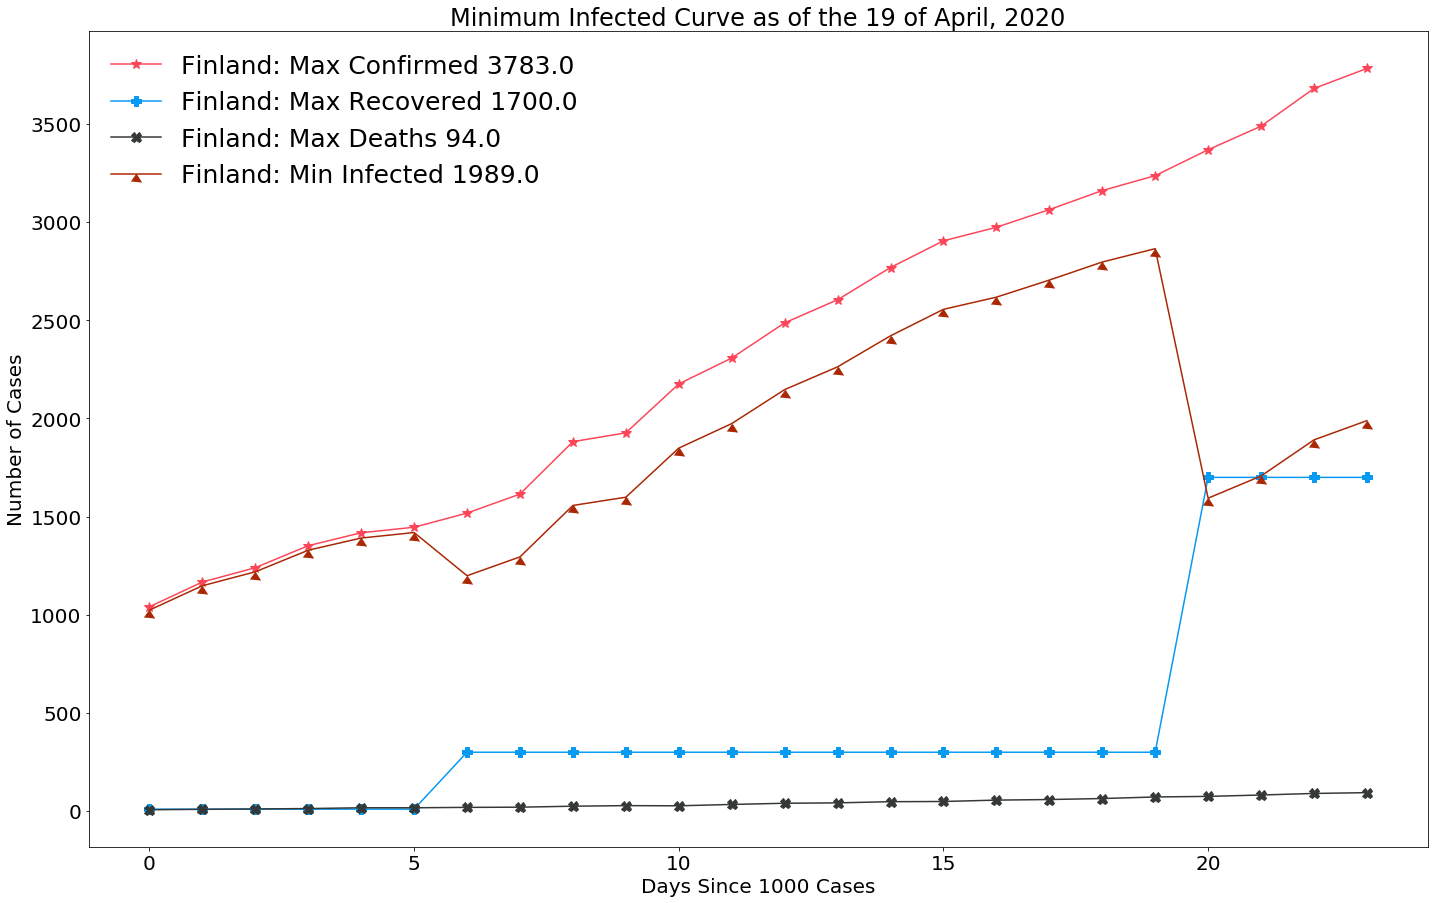

In [66]:
#fd4659  -  watermelon
#069af3  -  azure
#04f489  -  turquoise green
#f5bf03  -  golden
#bf77f6  -  light purple
#a8a495  -  greyish
#d1b26f  -  tan

#aa2704  -  rust red
#155084  -  light navy
#05480d  -  british racing green
#dc4d01  -  deep orange
#5f1b6b  -  indigo
#000000  -  black
#653700  -  brown

#59656d  -  slate grey
#343837  -  charcoal
#75bbfd  -  sky blue
#fdc1c5  -  pale rose

save_on = False
sizes = 10

f1, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(24, 15))

ax1.plot(Finland_len, Finland_1000['Confirmed'], 
         color = '#fd4659', 
         marker = '*', markersize = sizes, 
         label='Finland: Max Confirmed '+ str(Finland_1000['Confirmed'][Finland_len.size -1]))

ax1.plot(Finland_len, Finland_1000['Recovered'], 
         color = '#069af3', 
         marker = 'P', markersize = sizes, 
         label='Finland: Max Recovered '+ str(Finland_1000['Recovered'][Finland_len.size -1]))

ax1.plot(Finland_len, Finland_1000['Deaths'], 
         color = '#343837', 
         marker = 'X', markersize = sizes, 
         label='Finland: Max Deaths '+ str(Finland_1000['Deaths'][Finland_len.size -1]))

ax1.plot(Finland_len, Finland_1000['Infected'], 
         color = '#aa2704', 
         marker = 6, markersize = sizes, 
         label='Finland: Min Infected '+ str(Finland_1000['Infected'][Finland_len.size -1]))



ax1.legend(ncol=1, frameon=False, loc=2, scatterpoints=1, markerscale=1, fontsize=25)

#ax1.set_ylim(0,325000)

#ax1.xaxis.set_major_locator(MonthLocator())
#ax1.xaxis.set_major_formatter(DateFormatter('%b:%Y'))
#ax1.xaxis.set_minor_locator(DayLocator([15]))
#ax1.xaxis.set_minor_formatter(DateFormatter('%b:%d'))

#ax1.set_xlim([datetime.date(2020, 3, 8), datetime.date(2020, 4, 10)])


ax1.set_ylabel('Number of Cases')
ax1.set_xlabel('Days Since 1000 Cases')
ax1.set_title('Minimum Infected Curve as of the ' + EndDate)

if save_on:
    f1.savefig('CanadaMinInfected.png')
    f1.savefig('CanadaMinInfected.pdf')
    plt.close()
else:
    plt.show()

#fd4659  -  watermelon
#069af3  -  azure
#04f489  -  turquoise green
#f5bf03  -  golden
#bf77f6  -  light purple
#a8a495  -  greyish
#d1b26f  -  tan

#aa2704  -  rust red
#155084  -  light navy
#05480d  -  british racing green
#dc4d01  -  deep orange
#5f1b6b  -  indigo
#000000  -  black
#653700  -  brown

#59656d  -  slate grey
#343837  -  charcoal
#75bbfd  -  sky blue
#fdc1c5  -  pale rose

save_on = False
sizes = 10

f1, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(24, 15))

ax1.plot(Russia_len, Russia_1000['Confirmed'], 
         color = '#fd4659', 
         marker = '*', markersize = sizes, 
         label='Russia: Max Confirmed '+ str(Russia_1000['Confirmed'][Russia_len.size -1]))

ax1.plot(Russia_len, Russia_1000['Recovered'], 
         color = '#069af3', 
         marker = 'P', markersize = sizes, 
         label='Russia: Max Recovered '+ str(Russia_1000['Recovered'][Russia_len.size -1]))

ax1.plot(Russia_len, Russia_1000['Deaths'], 
         color = '#343837', 
         marker = 'X', markersize = sizes, 
         label='Russia: Max Deaths '+ str(Russia_1000['Deaths'][Russia_len.size -1]))

ax1.plot(Russia_len, Russia_1000['Infected'], 
         color = '#aa2704', 
         marker = 6, markersize = sizes, 
         label='Russia: Infected '+ str(Russia_1000['Infected'][Russia_len.size -1]))



ax1.legend(ncol=1, frameon=False, loc=2, scatterpoints=1, markerscale=1, fontsize=25)

#ax1.set_ylim(0,325000)

#ax1.xaxis.set_major_locator(MonthLocator())
#ax1.xaxis.set_major_formatter(DateFormatter('%b:%Y'))
#ax1.xaxis.set_minor_locator(DayLocator([15]))
#ax1.xaxis.set_minor_formatter(DateFormatter('%b:%d'))

#ax1.set_xlim([datetime.date(2020, 3, 8), datetime.date(2020, 4, 10)])


ax1.set_ylabel('Confirmed Cases')
ax1.set_xlabel('Days Since 1000 Cases')
ax1.set_title('Minimum Infected as of the ' + EndDate)

if save_on:
    f1.savefig('RussiaMinInfected.png')
    f1.savefig('RussiaMinInfected.pdf')
    plt.close()
else:
    plt.show()

#fd4659  -  watermelon
#069af3  -  azure
#04f489  -  turquoise green
#f5bf03  -  golden
#bf77f6  -  light purple
#a8a495  -  greyish
#d1b26f  -  tan

#aa2704  -  rust red
#155084  -  light navy
#05480d  -  british racing green
#dc4d01  -  deep orange
#5f1b6b  -  indigo
#000000  -  black
#653700  -  brown

#59656d  -  slate grey
#343837  -  charcoal
#75bbfd  -  sky blue
#fdc1c5  -  pale rose

save_on = False
sizes = 10

f1, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(24, 15))

ax1.plot(USA_len, USA_1000['Confirmed'], 
         color = '#fd4659', 
         marker = '*', markersize = sizes, 
         label='USA: Max Confirmed '+ str(USA_1000['Confirmed'][USA_len.size -1]))

ax1.plot(USA_len, USA_1000['Recovered'], 
         color = '#069af3', 
         marker = 'P', markersize = sizes, 
         label='USA: Max Recovered '+ str(USA_1000['Recovered'][USA_len.size -1]))

ax1.plot(USA_len, USA_1000['Deaths'], 
         color = '#343837', 
         marker = 'X', markersize = sizes, 
         label='USA: Max Deaths '+ str(USA_1000['Deaths'][USA_len.size -1]))

ax1.plot(USA_len, USA_1000['Infected'], 
         color = '#aa2704', 
         marker = 6, markersize = sizes, 
         label='USA: Infected '+ str(USA_1000['Infected'][USA_len.size -1]))



ax1.legend(ncol=1, frameon=False, loc=2, scatterpoints=1, markerscale=1, fontsize=25)

#ax1.set_ylim(0,325000)

#ax1.xaxis.set_major_locator(MonthLocator())
#ax1.xaxis.set_major_formatter(DateFormatter('%b:%Y'))
#ax1.xaxis.set_minor_locator(DayLocator([15]))
#ax1.xaxis.set_minor_formatter(DateFormatter('%b:%d'))

#ax1.set_xlim([datetime.date(2020, 3, 8), datetime.date(2020, 4, 10)])


ax1.set_ylabel('Confirmed Cases')
ax1.set_xlabel('Days Since 1000 Cases')
ax1.set_title('Minimum Infected as of the ' + EndDate)

if save_on:
    f1.savefig('USAMinInfected.png')
    f1.savefig('USAMinInfected.pdf')
    plt.close()
else:
    plt.show()

'''
    Document your code ya chub
    '''#fd4659  -  watermelon
#069af3  -  azure
#04f489  -  turquoise green
#f5bf03  -  golden
#bf77f6  -  light purple
#a8a495  -  greyish
#d1b26f  -  tan

#aa2704  -  rust red
#155084  -  light navy
#05480d  -  british racing green
#dc4d01  -  deep orange
#5f1b6b  -  indigo
#000000  -  black
#653700  -  brown

#59656d  -  slate grey
#343837  -  charcoal
#75bbfd  -  sky blue
#fdc1c5  -  pale rose
save_on = False
sizes = 10

f1, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(24, 15))

ax1.plot(China_len, China_1000['Confirmed'], 
         color = '#fd4659', 
         marker = '*', markersize = sizes, 
         label='China: Max Confirmed '+ str(China_1000['Confirmed'][China_len.size -1]))

ax1.plot(China_len, China_1000['Recovered'], 
         color = '#069af3', 
         marker = 'P', markersize = sizes, 
         label='China: Max Recovered '+ str(China_1000['Recovered'][China_len.size -1]))

ax1.plot(China_len, China_1000['Deaths'], 
         color = '#343837', 
         marker = 'X', markersize = sizes, 
         label='China: Max Deaths '+ str(China_1000['Deaths'][China_len.size -1]))

ax1.plot(China_len, China_1000["Infected"], 
         color = '#aa2704', 
         marker = 6, markersize = sizes, 
         label='China: Infected '+ str(China_1000['Infected'][China_len.size -1]))



ax1.legend(ncol=1, frameon=False, loc=2, scatterpoints=1, markerscale=1, fontsize=25)

#ax1.set_ylim(0,325000)

#ax1.xaxis.set_major_locator(MonthLocator())
#ax1.xaxis.set_major_formatter(DateFormatter('%b:%Y'))
#ax1.xaxis.set_minor_locator(DayLocator([15]))
#ax1.xaxis.set_minor_formatter(DateFormatter('%b:%d'))

#ax1.set_xlim([datetime.date(2020, 3, 8), datetime.date(2020, 4, 10)])


ax1.set_ylabel('Confirmed Cases')
ax1.set_xlabel('Days Since 1000 Cases')
ax1.set_title('Minimum Infected as of the ' + EndDate)

if save_on:
    f1.savefig('ChinaMinInfected.png')
    f1.savefig('ChinaMinInfected.pdf')
    plt.close()
else:
    plt.show()

#fd4659  -  watermelon
#069af3  -  azure
#04f489  -  turquoise green
#f5bf03  -  golden
#bf77f6  -  light purple
#a8a495  -  greyish
#d1b26f  -  tan

#aa2704  -  rust red
#155084  -  light navy
#05480d  -  british racing green'''
    Document your code ya chub
    '''
#dc4d01  -  deep orange
#5f1b6b  -  indigo
#000000  -  black
#653700  -  brown

#59656d  -  slate grey
#343837  -  charcoal
#75bbfd  -  sky blue
#fdc1c5  -  pale rose

save_on = False
sizes = 10

f1, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(24, 15))

ax1.plot(SKorea_len, SKorea_1000['Confirmed'], 
         color = '#fd4659', 
         marker = '*', markersize = sizes, 
         label='South Korea: Max Confirmed '+ str(SKorea_1000['Confirmed'][SKorea_len.size -1]))

ax1.plot(SKorea_len, SKorea_1000['Recovered'], 
         color = '#069af3', 
         marker = 'P', markersize = sizes, 
         label='South Korea: Max Recovered '+ str(SKorea_1000['Recovered'][SKorea_len.size -1]))

ax1.plot(SKorea_len, SKorea_1000['Deaths'], 
         color = '#343837', 
         marker = 'X', markersize = sizes, 
         label='South Korea: Max Deaths '+ str(SKorea_1000['Deaths'][SKorea_len.size -1]))

ax1.plot(SKorea_len, SKorea_1000['Infected'], 
         color = '#aa2704', 
         marker = 6, markersize = sizes, 
         label='South Korea: Infected '+ str(SKorea_1000['Infected'][SKorea_len.size -1]))



ax1.legend(ncol=1, frameon=False, loc=2, scatterpoints=1, markerscale=1, fontsize=25)

#ax1.set_ylim(0,325000)

#ax1.xaxis.set_major_locator(MonthLocator())
#ax1.xaxis.set_major_formatter(DateFormatter('%b:%Y'))
#ax1.xaxis.set_minor_locator(DayLocator([15]))
#ax1.xaxis.set_minor_formatter(DateFormatter('%b:%d'))

#ax1.set_xlim([datetime.date(2020, 3, 8), datetime.date(2020, 4, 10)])


ax1.set_ylabel('Confirmed Cases')
ax1.set_xlabel('Days Since 1000 Cases')
ax1.set_title('Minimum Infected as of the ' + EndDate)

if save_on:
    f1.savefig('SKoreaMinInfected.png')
    f1.savefig('SKoreaMinInfected.pdf')
    plt.close()
else:
    plt.show()

#fd4659  -  watermelon
#069af3  -  azure
#04f489  -  turquoise green
#f5bf03  -  golden
#bf77f6  -  light purple
#a8a495  -  greyish
#d1b26f  -  tan

#aa2704  -  rust red
#155084  -  light navy
#05480d  -  british racing green
#dc4d01  -  deep orange
#5f1b6b  -  indigo
#000000  -  black
#653700  -  brown

#59656d  -  slate grey
#343837  -  charcoal
#75bbfd  -  sky blue
#fdc1c5  -  pale rose
save_on = False
sizes = 10

f1, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(24, 15))

ax1.plot(Canada["NewCases"], fillstyle = 'none', 
         color='#653700', 
         marker = 'o', markersize = sizes, 
         label='Canada CSSE Data: Daily Infected')

ax1.plot(CanadaProv["NewCases"], fillstyle = 'none', 
         color='#155084', 
         marker = 's', markersize = sizes, 
         label='Canada Provincial Data: Daily Infected')

ax1.plot(BritCol["NewCases"], fillstyle = 'none', 
         color='#05480d', 
         marker = "P", markersize = sizes, 
         label='British Columbia: Daily Infected')

ax1.plot(Ontario["NewCases"], fillstyle = 'none', 
         color='#dc4d01', 
         marker = 'p', markersize = sizes, 
         label='Ontario: Daily Infected')

ax1.plot(Quebec["NewCases"], fillstyle = 'none', 
         color='#5f1b6b', 
         marker = "D", markersize = sizes, 
         label='Quebec: Daily Infected')


ax1.legend(ncol=1, frameon=False, loc=2, scatterpoints=1, markerscale=1, fontsize=25)

#ax1.set_ylim(0,325000)

ax1.xaxis.set_major_locator(DayLocator([1,15]))
ax1.xaxis.set_major_formatter(DateFormatter('%B:%d'))
#ax1.xaxis.set_minor_locator(DayLocator([15]))
#ax1.xaxis.set_minor_formatter(DateFormatter('%b:%d'))

#ax1.set_xlim([datetime.date(2020, 3, 8), datetime.date(2020, 4, 10)])


ax1.set_ylabel('Confirmed Cases')
plt.xticks(rotation=45)
ax1.set_title('Daily Cases as of the ' + EndDate)

if save_on:
    f1.savefig('CanadaDailyInfected.png')
    f1.savefig('CanadaDailyInfected.pdf')
    plt.close()
else:
    plt.show()

#fd4659  -  watermelon
#069af3  -  azure
#04f489  -  turquoise green
#f5bf03  -  golden
#bf77f6  -  light purple
#a8a495  -  greyish
#d1b26f  -  tan

#aa2704  -  rust red
#155084  -  light navy
#05480d  -  british racing green
#dc4d01  -  deep orange
#5f1b6b  -  indigo
#000000  -  black
#653700  -  brown

#59656d  -  slate grey
#343837  -  charcoal
#75bbfd  -  sky blue
#fdc1c5  -  pale rose

save_on = False
sizes = 10

f1, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(24, 15))


ax1.plot(Canada["Confirmed"], #fillstyle = 'none', 
         color='#653700', 
         marker = 'o', markersize = sizes, 
         label='Canada CSSE Data: '+ str(Canada['Confirmed'][Canada.index.size -1]))

ax1.plot(CanadaProv["Confirmed"], fillstyle = 'none', 
         color='#155084', linestyle = '--', 
         marker = 's', markersize = sizes, 
         label='Canada Provincial Data: '+ str(CanadaProv['Confirmed'][CanadaProv.index.size -1]))

ax1.plot(BritCol["Confirmed"], #fillstyle = 'none', 
         color='#05480d', 
         marker = "P", markersize = sizes, 
         label='British Columbia: '+ str(BritCol['Confirmed'][BritCol.index.size -1]))

ax1.plot(Ontario["Confirmed"], #fillstyle = 'none', 
         color='#dc4d01', 
         marker = 'p', markersize = sizes, 
         label='Ontario: '+ str(Ontario['Confirmed'][Ontario.index.size -1]))

ax1.plot(Quebec["Confirmed"], #fillstyle = 'none', 
         color='#5f1b6b', 
         marker = "D", markersize = sizes, 
         label='Quebec: '+ str(Quebec['Confirmed'][Quebec.index.size -1]))


ax1.legend(ncol=1, frameon=False, loc=2, scatterpoints=1, markerscale=1, fontsize=25)

ax1.xaxis.set_major_locator(DayLocator([1,15]))
ax1.xaxis.set_major_formatter(DateFormatter('%B:%d'))
#ax1.xaxis.set_minor_locator(DayLocator([15]))
#ax1.xaxis.set_minor_formatter(DateFormatter('%b:%d'))

ax1.set_xlim([datetime.date(2020, 3, 8), datetime.date(2020, 4, 16)])


ax1.set_ylabel('Confirmed Cases')
plt.xticks(rotation=45)
ax1.set_title('Canadian Confirmed Cases as of the ' + EndDate)

if save_on:
    f1.savefig('CanadaProvince.png')
    f1.savefig('CanadaProvince.pdf')
    plt.close()
else:
    plt.show()